In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import numpy as np
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import time
import math
from datetime import datetime
import matplotlib.pyplot as plt

Importing plotly failed. Interactive plots will not work.


In [3]:
# 设置中文字体
plt.rcParams['font.family'] = ['Arial Unicode MS']

In [4]:
### 基础函数模块
from utils import *

In [5]:
### prophet模块
from new_prophet import prophet_obj

In [6]:
### 后处理：校准模块
from calibration import cnt_calib, ratio_calib

In [7]:
### 测试模块
from Validation import cross_validation, get_cv_stats, display_cv_result

In [8]:
### 前处理：异常检测模块
from cout_covid_dates_full import cout_covid_dates_full, cout_covid_dates

In [9]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 500)

In [10]:
### 画图
def plot_fcst(df_plot, city_name):
    fig = plt.figure(figsize=(8, 5))
    
    df_plot['date'] = df_plot['ds'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
    df_plot = df_plot.rename(columns={'yhat':'y_pred','y':'y_true'})
    df_plot.index = df_plot['date']

    plt.plot(df_plot.index, df_plot['y_pred'], "r--", label='y_pred')
    plt.plot(df_plot.index, df_plot['y_true'], "b", label='y_true')
    plt.title('{}'.format(city_name))
    
    fig.autofmt_xdate()
    
    plt.grid("on")
    # plt.xlabel("day of month")
    # plt.ylabel('Target Var')
    plt.legend()
    plt.tight_layout()
    plt.show()
    

### 日期设置

In [11]:
jumpoff_date = '2023-12-02'
fcst_start_date = '2023-12-03'
fcst_end_date = '2024-02-09'

### 节假日生成

In [12]:
holidays = generate_cn_holidays()
holidays.tail()

,holiday,ds,lower_window,upper_window
4,zhongqiu,2016-09-15,-1,2
5,zhongqiu,2018-09-22,-1,2
6,zhongqiu,2019-09-13,-1,2
7,zhongqiu,2021-09-19,-1,2
8,zhongqiu,2022-09-10,-1,2


### 基础数据读取

In [26]:
data = pd.read_excel('./encrypt_model_data.xlsx')

In [27]:
df = data.copy()

## Prophet的日期固定命名为ds
df = df.rename(columns = {'order_date':'ds','dt':'ds',
                          'user_subsidy_rate':'subsidy_rate',
                          'total_driver_subsidy_rate':'dv_subsidy_rate',
                          'match_order_num': 'matched_order_num',
                          'city_name': 'city_type'
                         })

## 补贴率是影响单量重要的协变量
df['subsidy_rate'] = df['subsidy_rate'].fillna(0)

df['subsidy_rate_sqrt'] = df['subsidy_rate'].apply(lambda x: x**0.5)
df['subsidy_rate_square'] = df['subsidy_rate'].apply(lambda x: x**2)

In [28]:
## 以上海为例
df = df.query("city_type == '上海'")

## 以配对单预测为例
df['y'] = df['matched_order_num']

df.head()

,city_type,ds,subsidy_rate,matched_order_num,order_num,subsidy_rate_sqrt,subsidy_rate_square,y
0,上海,2017-01-01,0.000739,249.30,447.6,0.027192,5.467545e-07,249.30
1,上海,2017-01-02,0.000517,292.35,514.4,0.022740,2.673868e-07,292.35
2,上海,2017-01-03,0.000419,412.05,728.6,0.020460,1.752263e-07,412.05
3,上海,2017-01-04,0.000476,446.40,814.4,0.021827,2.269617e-07,446.40
4,上海,2017-01-05,0.000628,431.25,849.6,0.025050,3.937720e-07,431.25


## 1. 异常（主要是疫情）检测

In [17]:
detected_covid_dates = cout_covid_dates_full(
    df,
    detect_start_date = '2022-01-01', ## 2022年开始各地差异化疫情（2020是普遍疫情）
    cv_list = ['subsidy_rate'], ## 协变量
)

----------------------- detecting -----------------------
------ iteration 1 ------


11:50:16 - cmdstanpy - INFO - Chain [1] start processing
11:50:18 - cmdstanpy - INFO - Chain [1] done processing


------ iteration 2 ------


11:50:22 - cmdstanpy - INFO - Chain [1] start processing
11:50:24 - cmdstanpy - INFO - Chain [1] done processing


------ iteration 3 ------


11:50:28 - cmdstanpy - INFO - Chain [1] start processing
11:50:33 - cmdstanpy - INFO - Chain [1] done processing


------ iteration 4 ------


11:50:38 - cmdstanpy - INFO - Chain [1] start processing
11:50:43 - cmdstanpy - INFO - Chain [1] done processing


------ iteration 5 ------


11:50:50 - cmdstanpy - INFO - Chain [1] start processing
11:50:55 - cmdstanpy - INFO - Chain [1] done processing


------ iteration 6 ------


11:51:00 - cmdstanpy - INFO - Chain [1] start processing
11:51:04 - cmdstanpy - INFO - Chain [1] done processing


------ iteration 7 ------


11:51:08 - cmdstanpy - INFO - Chain [1] start processing
11:51:13 - cmdstanpy - INFO - Chain [1] done processing


------ iteration 8 ------


11:51:17 - cmdstanpy - INFO - Chain [1] start processing
11:51:22 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
detected_covid_dates

,holiday,ds,lower_window,upper_window
0,covid_0,2022-01-14,0,14
1,covid_1,2022-02-09,0,18
2,covid_2,2022-03-01,0,131
3,covid_3,2022-12-17,0,13
4,covid_4,2023-01-01,0,20
5,covid_5,2023-10-01,0,6


## 2. 测试

In [19]:
bkt_df = generate_backtest_df(
    jumpoff_date_lst = ['2023-04-01', '2023-06-01', '2023-09-01', '2023-10-01']
)
bkt_df

,jump_off_dt,fcst_stt_dt,fcst_end_dt
0,2023-04-01,2023-04-02,2023-05-01
1,2023-06-01,2023-06-02,2023-07-01
2,2023-09-01,2023-09-02,2023-10-01
3,2023-10-01,2023-10-02,2023-10-31


### 2.1 不把检测到的疫情加入节假日

Validating 4 Cutoff points
['2023-04-01', '2023-06-01', '2023-09-01', '2023-10-01']
  jump_off_date  daily_mape  pre_holiday_mape  holiday_mape  normal_mape  \
0    2023-04-01    0.403756          0.402441      0.435390     0.394529   
1    2023-06-01    0.402856          0.358281      0.749240     0.365130   
2    2023-09-01    0.693959          0.872077      0.786920     0.660075   
3    2023-10-01    0.610431               NaN      0.868124     0.558893   

   pct_monthly_error  daily_avg_pred  daily_avg_true  
0          -0.410650     4797.725296        8140.700  
1           0.384224    11230.344445        8113.095  
2           0.689507    13862.757194        8205.210  
3           0.585891    11951.580855        7536.195  

 Monthly MAPE: 0.51757

 Daily MAPE Mean: 0.52775


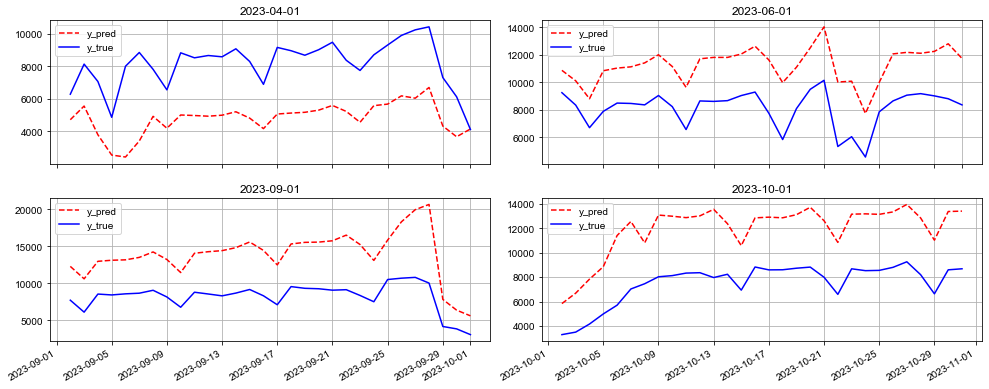

In [20]:
pm_test = prophet_obj(
    model_df = df,
    pf_params = {
        'seasonality_mode': 'additive', ## 季节模式，数量类指标如果取log就用加法，否则用乘法
        'interval_width': 0.8,
        'holidays': holidays,
        'daily_seasonality': False
    },
    default_training_start_dt = '2017-01-01', ## 视情况而定，如果早期数据噪音较大，则可考虑剔除
    default_training_end_dt = jumpoff_date, ## 对于测试来说，training_end_dt不重要
    if_log = True,
    extra_reg_lst = ['subsidy_rate']
)

### 并行运算
cv_res = cross_validation(pm_test, bkt_df, calib = None, parallel = 'processes') ## 不校正
cv_stats = get_cv_stats(cv_res)

### 作图
display_cv_result(cv_stats)

### 2.2 把检测到的疫情作为一次性节假日加入模型

Validating 4 Cutoff points
['2023-04-01', '2023-06-01', '2023-09-01', '2023-10-01']
  jump_off_date  daily_mape  pre_holiday_mape  holiday_mape  normal_mape  \
0    2023-04-01    0.092071          0.095572      0.228351     0.050487   
1    2023-06-01    0.060317          0.056214      0.216896     0.041258   
2    2023-09-01    0.085022          0.149660      0.094587     0.075747   
3    2023-10-01    0.096878               NaN      0.302129     0.055828   

   pct_monthly_error  daily_avg_pred  daily_avg_true  
0           0.010139     8223.239839        8140.700  
1           0.017023     8251.205646        8113.095  
2           0.078236     8847.152003        8205.210  
3           0.076394     8111.915407        7536.195  

 Monthly MAPE: 0.04545

 Daily MAPE Mean: 0.08357


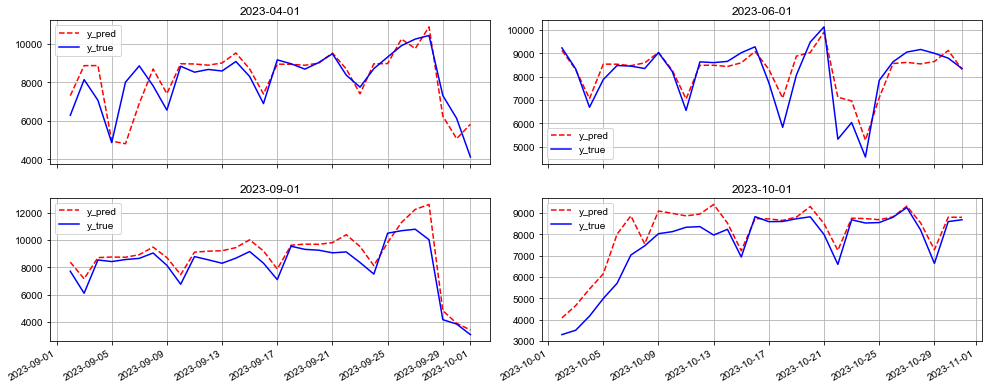

In [21]:
pm_test = prophet_obj(
    model_df = df,
    pf_params = {
        'seasonality_mode': 'additive', ## 季节模式，数量类指标如果取log就用加法，否则用乘法
        'interval_width': 0.8,
        'holidays': pd.concat([holidays, detected_covid_dates], ignore_index = True),
        'daily_seasonality': False
    },
    default_training_start_dt = '2017-01-01', ## 视情况而定，如果早期数据噪音较大，则可考虑剔除
    default_training_end_dt = jumpoff_date, ## 对于测试来说，training_end_dt不重要
    if_log = True,
    extra_reg_lst = ['subsidy_rate']
)

# calib = cnt_calib(adj_level = 'm') ### 校准方式为数量校准，校准强度为中等

### 并行运算
cv_res = cross_validation(pm_test, bkt_df, calib = None, parallel = 'processes')
cv_stats = get_cv_stats(cv_res)

### 作图
display_cv_result(cv_stats)

### 2.3. 1.把检测到的疫情加入节假日  2.校准

Validating 4 Cutoff points
['2023-04-01', '2023-06-01', '2023-09-01', '2023-10-01']
  jump_off_date  daily_mape  pre_holiday_mape  holiday_mape  normal_mape  \
0    2023-04-01    0.091838          0.094726      0.228501     0.050262   
1    2023-06-01    0.054967          0.057841      0.209751     0.035260   
2    2023-09-01    0.071578          0.135778      0.081370     0.062329   
3    2023-10-01    0.074186               NaN      0.248817     0.039260   

   pct_monthly_error  daily_avg_pred  daily_avg_true  
0           0.008703     8211.546394        8140.700  
1           0.011052     8202.761793        8113.095  
2           0.065216     8740.323869        8205.210  
3           0.032324     7779.795816        7536.195  

 Monthly MAPE: 0.02932

 Daily MAPE Mean: 0.07314


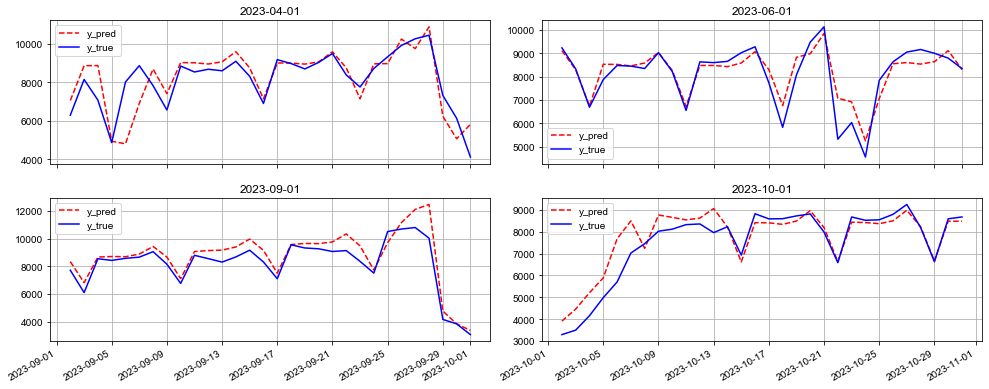

In [22]:
pm_test = prophet_obj(
    model_df = df,
    pf_params = {
        'seasonality_mode': 'additive', ## 季节模式，数量类指标如果取log就用加法，否则用乘法
        'interval_width': 0.8,
        'holidays': pd.concat([holidays, detected_covid_dates], ignore_index = True),
        'daily_seasonality': False
    },
    default_training_start_dt = '2017-01-01', ## 视情况而定，如果早期数据噪音较大，则可考虑剔除
    default_training_end_dt = jumpoff_date, ## 对于测试来说，training_end_dt不重要
    if_log = True,
    extra_reg_lst = ['subsidy_rate']
)

calib = cnt_calib(adj_level = 'm') ### 校准方式为数量校准，校准强度为中等

### 并行运算
cv_res = cross_validation(pm_test, bkt_df, calib = calib, parallel = 'processes')
cv_stats = get_cv_stats(cv_res)

### 作图
display_cv_result(cv_stats)

## 3. 预测

11:52:35 - cmdstanpy - INFO - Chain [1] start processing
11:52:41 - cmdstanpy - INFO - Chain [1] done processing


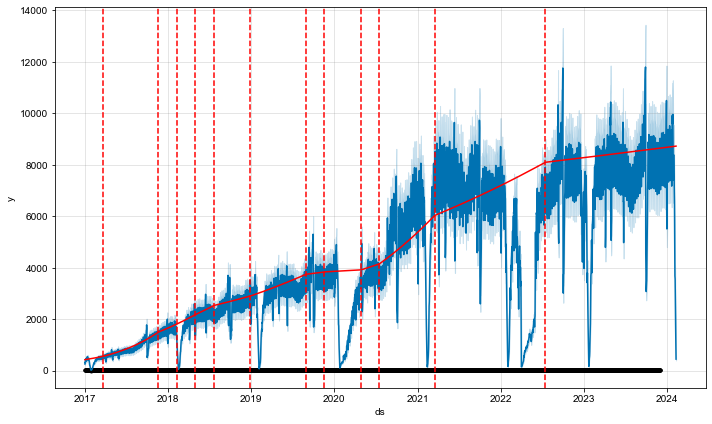

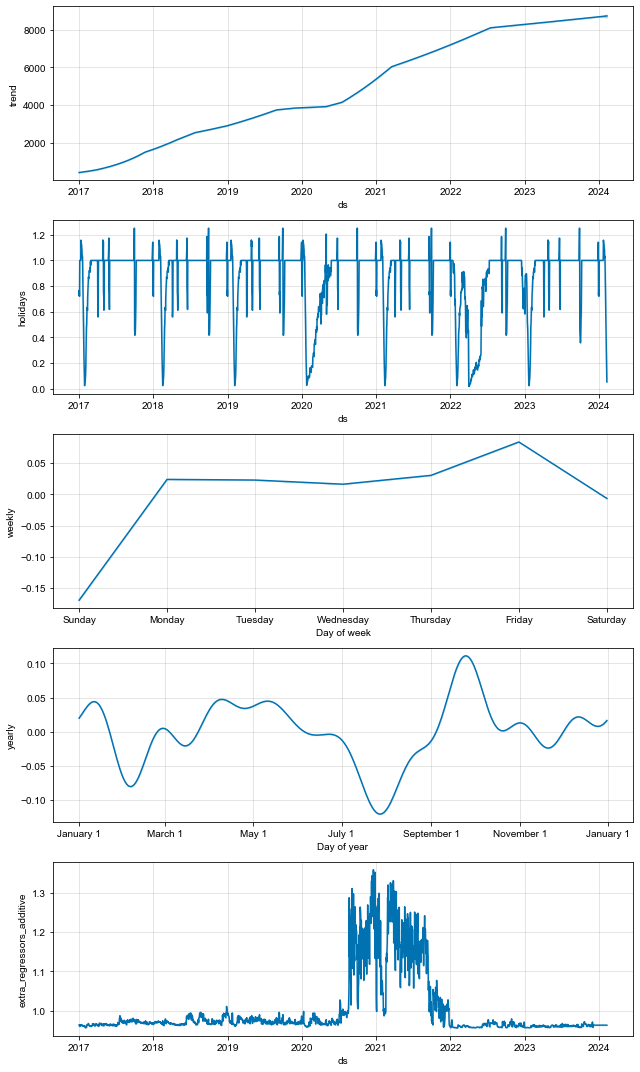

In [23]:
pm_pred = prophet_obj(
    model_df = df,
    pf_params = {
        'seasonality_mode': 'additive', ## 季节模式，数量类指标如果取log就用加法，否则用乘法
        'interval_width': 0.8,
        'holidays': pd.concat([holidays, detected_covid_dates], ignore_index = True),
        'daily_seasonality': False
    },
    default_training_start_dt = '2017-01-01', ## 视情况而定，如果早期数据噪音较大，则可考虑剔除
    default_training_end_dt = jumpoff_date, ## 对于测试来说，training_end_dt不重要
    if_log = True,
    extra_reg_lst = ['subsidy_rate']
)

### 预测
pred_df = pm_pred.predict(
    jump_off_date = jumpoff_date,
    fcst_stt_date = fcst_start_date,
    fcst_end_date = fcst_end_date,
    default_reg = 'Auto',
    if_plot = True, ## 是否将时序decompose结果打印
)

### 校正
calib = cnt_calib(adj_level = 'm') ### 校准方式为数量校准，校准强度为中等
pred_df = calib.adj_fcst(pred_df)


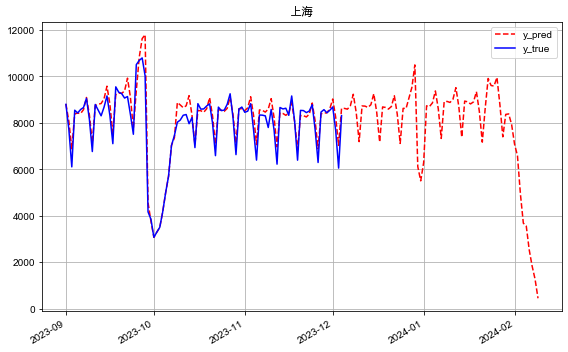

In [24]:
plot_fcst(pred_df.query("ds >= '2023-09-01'"), city_name = '上海')

### 比率类指标预测：以配对率为例

In [29]:
df['y'] = df['matched_order_num']/df['order_num']

11:56:26 - cmdstanpy - INFO - Chain [1] start processing
11:56:32 - cmdstanpy - INFO - Chain [1] done processing


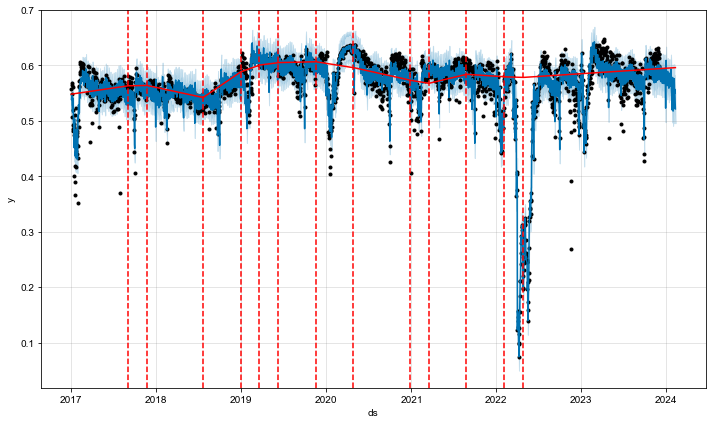

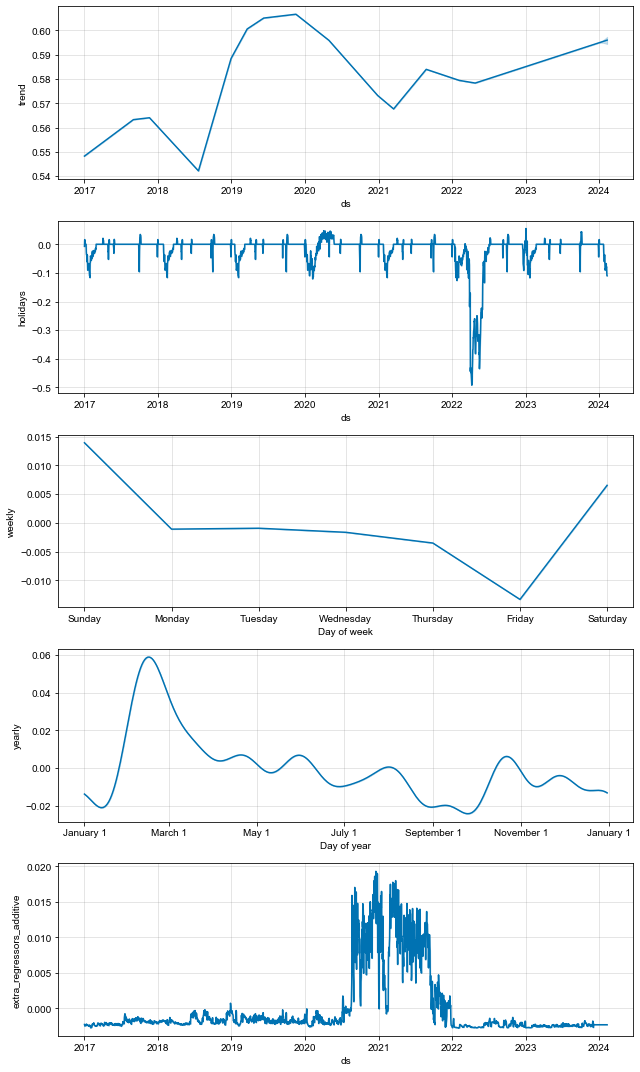

In [30]:
pm_pred = prophet_obj(
    model_df = df,
    pf_params = {
        'seasonality_mode': 'additive', ## 季节模式，数量类指标如果取log就用加法，否则用乘法
        'interval_width': 0.8,
        'holidays': pd.concat([holidays, detected_covid_dates], ignore_index = True),
        'daily_seasonality': False
    },
    default_training_start_dt = '2017-01-01', ## 视情况而定，如果早期数据噪音较大，则可考虑剔除
    default_training_end_dt = jumpoff_date, ## 对于测试来说，training_end_dt不重要
    if_log = False, ### 比率类指标不取log
    extra_reg_lst = ['subsidy_rate']
)

### 预测
pred_df = pm_pred.predict(
    jump_off_date = jumpoff_date,
    fcst_stt_date = fcst_start_date,
    fcst_end_date = fcst_end_date,
    default_reg = 'Auto',
    if_plot = True, ## 是否将时序decompose结果打印
)

### 校正
calib = ratio_calib(adj_level = 'm') ### 校准方式为比率校准，校准强度为中等
pred_df = calib.adj_fcst(pred_df)

In [ ]:
plot_fcst(pred_df.query("ds >= '2023-09-01'"), city_name = '上海')